<a href="https://colab.research.google.com/github/finardi/WatSpeed_LLM_foundation/blob/main/Module_3_GPTScore_using_LLMs_for_assessing_text_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3 - GPTScore - using LLMs for assessing text quality.ipynb

In this notebook, we present an example of using large language models to assess the quality of automatically generated text. For this, we will replicate part of the experiments performed by [GPTScore](https://arxiv.org/pdf/2302.04166.pdf)'s authors and compare our results rather those reported in the paper.

To do so, we will apply a pipeline that comprises the following steps:
1. Downloading and loading the [SummEval dataset](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00373/100686/SummEval-Re-evaluating-Summarization-Evaluation).
2. Preparing the data.
3. Using FLAN-T5-base for generating the scores.
4. Computing the correlations of the GPTScore values with the human annotations from SummEval.

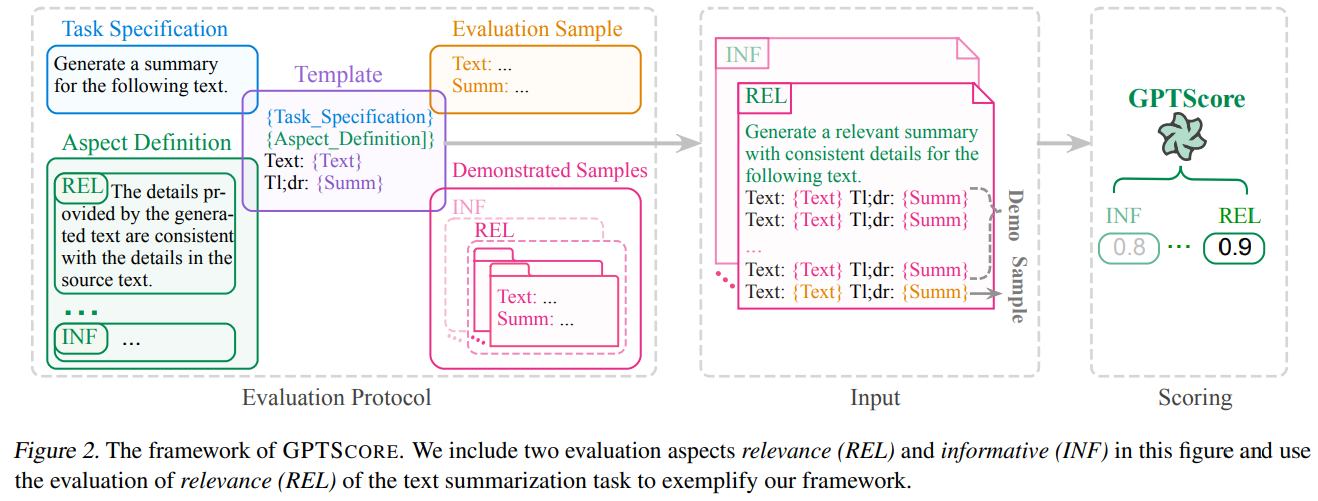

Hardware requirements:
- This notebook was tested on Google Colab Pro, using a NVIDIA A100 GPU.
- You can run using a smaller GPU, but it may require using a smaller model.

# Installing required packages

In this example, we have to install two libraries:  `transformers` and `datasets`, both from Hugging Face. [Hugging Face](https://huggingface.co/) is an AI startup that has gained significant traction in the NLP community recently. It provides a suite of open-source tools and libraries, making it easy for developers and researchers to work with state-of-the-art NLP models.

**`transformers`**:

Transformers is an open-source library for NLP developed by Hugging Face. It provides state-of-the-art pre-trained models for various NLP tasks, such as text classification, sentiment analysis, question-answering, named entity recognition, etc. The library is built on top of PyTorch and TensorFlow and provides easy-to-use interfaces to access pre-trained models and fine-tune them on specific tasks. The library also provides tools for training custom models and sharing them with the community.

**`datasets`**:

Datasets is another open-source library developed by Hugging Face that provides a collection of preprocessed datasets for various NLP tasks, such as sentiment analysis, natural language inference, machine translation, and many more. The library provides a unified API to access these datasets, making it easy to load, process, and analyze them.

In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 23.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 104.6 MB/s eta 0:0

In addition, we will clone the GPTScore repository from GitHub in this environment, which allows us to use the GPTScore package to compute text scores.

In [ ]:
!git clone https://github.com/jayralencar/GPTScore.git

Cloning into 'GPTScore'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 71 (delta 25), reused 54 (delta 14), pack-reused 0
Unpacking objects: 100% (71/71), 858.62 KiB | 6.31 MiB/s, done.


# Setting the device

In this example, we will use a GPU to speed up the processing of our model. GPUs (Graphics Processing Units) are specialized processors that are optimized for performing large-scale computations in parallel. By using a GPU, we can accelerate the training and inference of a machine learning model, which can significantly reduce the time required to complete these tasks.

Before we begin, we need to check whether a GPU is available and select it as the default device for our PyTorch operations. This is because PyTorch can use either a CPU or a GPU to perform computations, and by default, it will use the CPU. 

For using a GPU in Google Colab: 
1. Click on the "Runtime" menu at the top of the screen.
2. From the dropdown menu, click on "Change runtime type".
3. In the popup window that appears, select "GPU" as the hardware accelerator.
4. Click on the "Save" button.

That's it! Now you can use the GPU for faster computations in your notebook. 

In [ ]:
!nvidia-smi

Sat May 13 12:03:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Downloading Data

## Download CNN/DM dataset

To demonstrate the use of the GPTScore in text summarization, we will download the CNN/Daily Mail dataset. The CNN/Daily Mail is a popular dataset used for text summarization tasks. To download the dataset, we will make use of the **`load_dataset`** function from the Hugging Face's **`datasets`** library. The following code downloads the dataset and loads the version 1.0.0 of the dataset into the **`dataset`** variable:


In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="1.0.0")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/1.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The below code is using the **`pandas`** library to create a DataFrame from the **`test`** split of the CNN/Daily Mail dataset. 

The DataFrame is a two-dimensional table where each column can have a different data type. In this case, each row of the DataFrame represents a document and the columns represent metadata associated with the document. The DataFrame will allow us to manipulate and analyze the dataset in a more convenient way, such as filtering or sorting by metadata columns, or merging with other DataFrames. The **`pd.DataFrame`** function takes a dictionary-like object (in this case, **`dataset['test']`**) as input and returns a DataFrame.

In [ ]:
import pandas as pd

df = pd.DataFrame(dataset['test'])

## Download SummEval annotations

The next step in this process is to download the SummEval annotations, which contain human evaluations of automatically generated summaries of the CNN/DM documents. These annotations will be useful to evaluate the quality of the summaries produced by the models that we will use.

Check SummEval [paper](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00373/100686) for more details.

In [ ]:
!wget https://storage.googleapis.com/sfr-summarization-repo-research/model_annotations.aligned.jsonl

--2023-05-13 12:05:47--  https://storage.googleapis.com/sfr-summarization-repo-research/model_annotations.aligned.jsonl
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5839062 (5.6M) [application/octet-stream]
Saving to: ‘model_annotations.aligned.jsonl’

model_annotations.a 100%[===================>]   5.57M  5.47MB/s    in 1.0s    

2023-05-13 12:05:48 (5.47 MB/s) - ‘model_annotations.aligned.jsonl’ saved [5839062/5839062]



In the next cell, we load the SummEval annotations to a list of dictionaries.

In [ ]:
import json
f = open("model_annotations.aligned.jsonl","r")
data = [json.loads(l) for l in f.readlines()]

# Preparing Data

## Extract data and construct prompts

GPTScore proposes using two methods for computing scores for the summaries:
* **Vanilla:** with
non-instruction and non-demonstration (e.g.,`{src} Tl;dr {hypo}`)
* **Instruction:** with a target description as instruction (e.g., `Generate factually consistent summary for the following text: {item}\n\nTl;dr {hypo}`

In the following cell, we extract the data from SummEval and CNN/DM and create the vanilla and instruction prompts.

In [ ]:
# extracting source documents
scrs = [df[df["id"]==item['id'].split("-")[-1]]["article"].item() for item in data]
# extracting target summaries
tgts = [item["decoded"] for item in data]
# creating the vanilla prompt
srcs_vanilla = [f"{item} Tl;dr " for item in scrs]
# creating the instruction prompt
srcs_instruction = [f"Generate factually consistent summary for the following text: {item}\n\nTl;dr " for item in scrs]

print(srcs_vanilla[0])
print(srcs_instruction[0])

Paul Merson has restarted his row with Andros Townsend after the Tottenham midfielder was brought on with only seven minutes remaining in his team's 0-0 draw with Burnley on Sunday. 'Just been watching the game, did you miss the coach? #RubberDub #7minutes,' Merson put on Twitter. Merson initially angered Townsend for writing in his Sky Sports column that 'if Andros Townsend can get in (the England team) then it opens it up to anybody.' Paul Merson had another dig at Andros Townsend after his appearance for Tottenham against Burnley . Townsend was brought on in the 83rd minute for Tottenham as they drew 0-0 against Burnley . Andros Townsend scores England's equaliser in their 1-1 friendly draw with Italy in Turin on Tuesday night . The former Arsenal man was proven wrong when Townsend hit a stunning equaliser for England against Italy and he duly admitted his mistake. 'It's not as though I was watching hoping he wouldn't score for England, I'm genuinely pleased for him and fair play to

## Extracting annotations from SummEval.

In SummEval, annotators were asked to rate summaries considering four different aspects:

1. **Consistency**: the factual alignment between the summary and the summarized source. 
2. **Coherence**: the collective quality of all sentence.
3. **Relevance**: selection of important content from the source. 
4. **Fluency**: the quality of individual sentences.

Three expert annotators participated in the research (`expert_annotations`). Five crowd-sourced annotators were hired through the Amazon Mechanical Turk platform (`turker_annotations`).

We will test the **consistency**, but you can change this notebook to see how it works regarding the other aspects.

In [ ]:
import pandas as pd

aspect = "consistency" # ["consistency","coherence","fluency","relevance"]

rates = []
for item in data:
  r = {}
  for i, ex in enumerate(item['expert_annotations']):
    r["expert_{0}".format(i+1)] = ex[aspect]
  for i, ex in enumerate(item['turker_annotations']):
    r["turker_{0}".format(i+1)] = ex[aspect]
  rates.append(r)
rates_df = pd.DataFrame(rates)
rates_df.head()

,expert_1,expert_2,expert_3,turker_1,turker_2,turker_3,turker_4,turker_5
0,1,1,1,3,3,3,3,3
1,5,5,5,3,3,3,3,3
2,5,5,5,5,4,5,5,2
3,5,5,5,5,5,5,5,5
4,5,5,5,4,4,4,4,4


We calculate the mean value the annotators gave to the same summary.

In [ ]:
rates_df["expert_mean"] = rates_df[["expert_1","expert_2","expert_3"]].mean(axis=1)

rates_df["turker_mean"] = rates_df[["turker_1","turker_2","turker_3","turker_4","turker_5"]].mean(axis=1)

rates_df["all_mean"] = rates_df[["turker_1","turker_2","turker_3","turker_4","turker_5","expert_1","expert_2","expert_3"]].mean(axis=1)

# Using FLAN-T5-base for generating the scores.

The given code creates an instance of the **`FLANScorer`** class from the **`GPTScore.flan_score`** module, which is used to compute the FLAN score for the generated summaries. The **`FLANScorer`** takes two arguments: **`device`** and **`checkpoint`**. 

The **`device`** specifies whether to use a GPU or CPU for computations. 

The **`checkpoint`** argument specifies the path or name of the pre-trained model checkpoint to be used for scoring. In this case, the **`checkpoint`** is set to **`'google/flan-t5-xl'`**, which is the name of the pre-trained T5 transformer model checkpoint provided by Google on the Hugging Face model hub.

This notebook was tested using Google Colab PRO with a NVIDIA A100 GPU. If you don't have access to Colab PRO, you can try using a smaller version of Flan-T5, such as **`google/flan-t5-base`**.

In [ ]:
from GPTScore.flan_score import FLANScorer

scorer = FLANScorer(device=device, checkpoint='google/flan-t5-xl')

# If don't have access to Colab PRO, you can use a smaller model:
# scorer = FLANScorer(device=device, checkpoint='google/flan-t5-base')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Vanilla Scoring

In the following code, we perform the scoring using the vanilla prompts. We define a batch size of 8 to limit the memory usage.

If you get CUDA out of memory, you can change the **`BATCH_SIZE`** to a lower number.

This code performs vanilla scoring by calling the **`score`** method of the **`FLANScorer`** object **`scorer`**. The **`score`** method is called with three parameters: **`srcs_vanilla`**, `tgts`, and **`BATCH_SIZE`**. 

The scores generated by the **`score`** method are stored in a new column called **`"vanilla"`** in the pandas dataframe **`rates_df`**.

In [ ]:
BATCH_SIZE = 8
rates_df["vanilla"] = scorer.score(srcs_vanilla, tgts,BATCH_SIZE)

100%|██████████| 200/200 [03:34<00:00,  1.07s/it]


## Instruction Scoring

The code below, we perform the instruction scoring and store the scores in a column called **`instruction`** in the **`rates_df`** dataframe.

In [ ]:
rates_df["instruction"] = scorer.score(srcs_instruction, tgts,16)

100%|██████████| 100/100 [03:31<00:00,  2.12s/it]


# 4. Compute Correlations

The cell below computes the Spearman's rank correlation coefficient between the rates columns of the **`rates_df`** dataframe.

The [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is a statistical measure that measures the strength and direction of association between two variables. In the context of the STS task, it measures the correlation between the predicted similarity scores produced by the model and the human-labeled similarity scores in the test dataset. 

The Spearman's rank correlation coefficient ranges from -1 to 1, where a value of 1 indicates a perfect positive correlation, 0 indicates no correlation, and -1 indicates a perfect negative correlation. Therefore, a higher Spearman's rank correlation coefficient value indicates that the model predictions are closer to the human scores, which is a good indicator of model performance.

The Spearman's rank correlation coefficient can be represented using the following equation:

\begin{equation}
r_s = 1 - \frac{6\sum d_i^2}{n(n^2-1)}
\end{equation}

where $r_s$ is the Spearman's rank correlation coefficient, $d_i$ is the difference between the ranks of the corresponding values in the two variables, and $n$ is the number of observations. The number 6 is a constant that is used to normalize the coefficient. It makes the coefficient fall within the range of -1 to +1.


In [ ]:
cols = ["expert_mean","turker_mean","all_mean","vanilla","instruction"]
corr = rates_df[cols].corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm')

,expert_mean,turker_mean,all_mean,vanilla,instruction
expert_mean,1.000000,-0.010086,0.425279,0.441327,0.446135
turker_mean,-0.010086,1.000000,0.851581,0.084473,0.078981
all_mean,0.425279,0.851581,1.000000,0.286672,0.283002
vanilla,0.441327,0.084473,0.286672,1.000000,0.989304
instruction,0.446135,0.078981,0.283002,0.989304,1.000000


#5. Compare your results with GPTScore
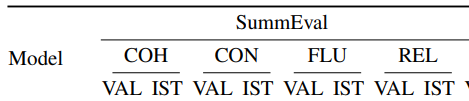

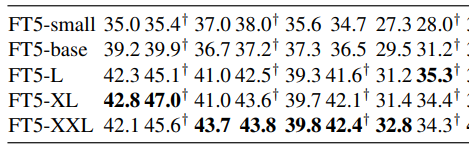

The above table shows the GPTScore official results. **VAL** refer to the vanilla prompt, while **IST** refer to the instruction prompt.

The acronyms in the header stand for:
* COH: coherence
* CON: consistency
* FLU: fluency
* REL: relevancy

Notice that the results we obtained differ from those reported in the paper. The GPTScore paper is unclear if the authors computed correlations with **`all_mean`**. Our results are closer to the **`expert_mean`**. So, we could say that the authors used **`expert_mean`** instead.